# stadvdbvdvbdbvbdb mco1

In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Database Connection Setup

In [ ]:
# MySQL Connection Details 

username = "root"
password = "admin"
host = "localhost"
port = "3306"
database = "stadvdb_imdb"

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

try:
    with engine.connect() as conn:
        tables = pd.read_sql("SHOW TABLES;", conn)
    print("Successfully connected to the database!")
    display(tables)
except Exception as e:
    print("Connection failed:", e)

Successfully connected to the database!


,Tables_in_stadvdb_imdb
0,dim_movie
1,director_profession_bridge
2,directors_dt
3,genre_dt
4,name_basics
5,profession_dt
6,title_akas
7,title_basics
8,title_crew
9,title_director_bridge


In [66]:
# Query to count rows per table
table_names = [
    "dim_movie", "director_profession_bridge", "directors_dt", "genre_dt",
    "name_basics", "profession_dt", "title_akas", "title_basics",
    "title_crew", "title_director_bridge", "title_episode", "title_ft",
    "title_genre_bridge", "title_principals", "title_ratings", "type_dt"
]

counts = []
with engine.connect() as conn:
    for table in table_names:
        result = pd.read_sql(f"SELECT COUNT(*) AS row_count FROM {table};", conn)
        counts.append({"table_name": table, "row_count": int(result['row_count'][0])})

pd.DataFrame(counts).sort_values(by="row_count", ascending=False)


,table_name,row_count
13,title_principals,92485887
6,title_akas,44190547
12,title_genre_bridge,15167823
8,title_crew,11932624
4,name_basics,10293867
11,title_ft,9775512
7,title_basics,9775512
10,title_episode,9188140
9,title_director_bridge,5877051
14,title_ratings,1617103


# Movie Search Queries
1. Be able to search keywords
2. By star rating (ex. 1.0 to 1.9)
  - Has a weighted system for higher vote counts
3. Filtering by genre
4. Have settable minimum number of votes

All queries will use the tables:
- `dim_movie` – Main movie details (title, year, genre, etc.)
- `title_ratings` – Average rating and vote counts
- `title_genre_bridge` and `genre_dt` – For genre relationships

In [ ]:
# Search Movies by Keyword
def search_movies_by_keyword(keyword, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE m.primaryTitle LIKE :keyword
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": f"%{keyword}%", "limit": limit})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
search_movies_by_keyword("Matrix", limit=10)

Query executed in 0.217 seconds


,tconst,title,startYear,averageRating,numVotes
0,tt0133093,The Matrix,1999.0,8.7,2188660
1,tt2990982,The Divine Matrix,2008.0,8.2,9
2,tt4413244,Matrix of Love,2008.0,8.1,21
3,tt0234215,The Matrix Reloaded,2003.0,7.2,658617
4,tt16409916,Rifftrax: The Matrix,2006.0,7.1,22
5,tt1830851,The Matrix Revolutions Revisited,2004.0,6.8,50
6,tt0242653,The Matrix Revolutions,2003.0,6.7,566097
7,tt11199234,Aufstand in der Matrix,2019.0,6.7,6
8,tt1499960,The Living Matrix,2009.0,6.6,195
9,tt13502978,Matrix xxx parody,2020.0,6.3,11


In [ ]:
# Filter Movies by Rating Range with Weighting

def filter_by_rating_range(min_rating, max_rating, min_votes=1000, limit=10):
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes

        query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating AS R,
            r.numVotes AS v,
            ((r.numVotes / (r.numVotes + {m})) * r.averageRating 
             + ({m} / (r.numVotes + {m})) * {C}) AS weighted_rating
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.averageRating BETWEEN {min_rating} AND {max_rating}
        AND r.numVotes >= {m}
        ORDER BY weighted_rating DESC
        LIMIT {limit};
        """
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_rating_range(1.0, 1.9, min_votes=5000, limit=10)

Query executed in 5.345 seconds


,tconst,title,R,v,weighted_rating
0,tt0057507,The Skydivers,1.9,5054,4.406724
1,tt5617916,Airplane Mode,1.9,5189,4.373511
2,tt2071491,Jurassic Shark,1.5,5170,4.174789
3,tt1674047,Birdemic 2: The Resurrection,1.5,5218,4.162224
4,tt0060753,Red Zone Cuba,1.6,6591,3.903736
5,tt7535868,Oha Diyorum,1.6,7108,3.805368
6,tt0364986,Ben & Arthur,1.9,8347,3.788260
7,tt0953989,Yes Sir,1.5,7098,3.748520
8,tt0473310,Ram Gopal Varma Ki Aag,1.4,7202,3.670333
9,tt4404474,Potato Salad,1.3,7161,3.619102


In [ ]:
# Filter Movies by Genre

def filter_by_genre(genreName, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
        JOIN genre_dt AS g ON tg.genreID = g.genreID
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE g.genreName = :genre
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genreName, "limit": limit})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_genre("Drama", limit=10)

Query executed in 7.675 seconds


,tconst,title,genre,averageRating,numVotes
0,tt36693357,Funérailles (Non ti voglio),Drama,10.0,12
1,tt26711080,Romeo and Benvolio,Drama,10.0,28
2,tt32373411,Papa Buka,Drama,10.0,10
3,tt26445214,The Paper Bag Plan,Drama,9.9,10
4,tt2777020,Lost Division,Drama,9.9,32
5,tt27235232,West of Greatness: The Story of the Westwego M...,Drama,9.9,11
6,tt22488252,Circumcision,Drama,9.9,15
7,tt1344645,My Father's Daughter,Drama,9.8,14
8,tt13388966,A Better Life,Drama,9.8,66
9,tt10423548,Apoteose,Drama,9.8,88


In [ ]:
# Filter by Minimum Votes

def filter_by_min_votes(min_votes=5000, limit=10):
    query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.numVotes >= {min_votes}
        ORDER BY r.averageRating DESC
        LIMIT {limit};
    """
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_min_votes(min_votes=10000, limit=10)

Query executed in 7.419 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt0259534,Ramayana: The Legend of Prince Rama,9.1,17261
4,tt33175825,Attack on Titan the Movie: The Last Attack,9.1,20280
5,tt0468569,The Dark Knight,9.1,3076473
6,tt28717622,Bomb,9.0,14443
7,tt0167260,The Lord of the Rings: The Return of the King,9.0,2108342
8,tt0050083,12 Angry Men,9.0,949034
9,tt0071562,The Godfather Part II,9.0,1452533


## Query Performance and Optimization

In [ ]:
# helper function for EXPLAIN

def explain_query(sql): 
    explain_sql = f"EXPLAIN {sql}"
    with engine.connect() as conn:
        df = pd.read_sql(explain_sql, conn)
    return df

In [ ]:
# Analyzing Keyword Search Query
keyword_sql = """
SELECT 
    m.tconst,
    m.primaryTitle,
    m.startYear,
    r.averageRating,
    r.numVotes
FROM dim_movie AS m
JOIN title_ratings AS r ON m.tconst = r.tconst
WHERE m.primaryTitle LIKE '%Matrix%'
ORDER BY r.averageRating DESC
LIMIT 10;
"""

print("Execution Plan for Keyword Search")
explain_query(keyword_sql)

Execution Plan for Keyword Search


,id,select_type,table,partitions,type,possible_keys,key,key_len,ref,rows,filtered,Extra
0,1,SIMPLE,m,None,ALL,None,None,None,None,334755,11.11,Using where; Using temporary; Using filesort
1,1,SIMPLE,r,None,eq_ref,PRIMARY,PRIMARY,50,stadvdb_imdb.m.tconst,1,100.00,Using where


In [ ]:
# Safe Index Creation
index_statements = {
    "idx_movie_tconst": "CREATE INDEX idx_movie_tconst ON dim_movie(tconst(12));",
    "idx_movie_title": "CREATE INDEX idx_movie_title ON dim_movie(primaryTitle(100));",
    "idx_ratings_tconst": "CREATE INDEX idx_ratings_tconst ON title_ratings(tconst(12));",
    "idx_genre_id": "CREATE INDEX idx_genre_id ON genre_dt(genreID);"
}

with engine.connect() as conn:
    for idx_name, stmt in index_statements.items():
        table_name = stmt.split("ON")[1].split("(")[0].strip()
        check_query = f"SHOW INDEX FROM {table_name} WHERE Key_name = '{idx_name}';"
        existing = pd.read_sql(check_query, conn)
        
        if existing.empty:
            conn.execute(text(stmt))
            print(f"Created index: {idx_name}")
        else:
            print(f"Index already exists: {idx_name}")


Index already exists: idx_movie_tconst
Index already exists: idx_movie_title
Index already exists: idx_ratings_tconst
Index already exists: idx_genre_id


In [ ]:
# Add missing bridge table indexes for optimization
with engine.connect() as conn:
    conn.execute(text("CREATE INDEX idx_tg_genreID ON title_genre_bridge(genreID);"))
    conn.execute(text("CREATE INDEX idx_tg_tconst ON title_genre_bridge(tconst(12));"))
print("Added missing indexes on title_genre_bridge (genreID, tconst).")

In [ ]:
with engine.connect() as conn:
    conn.execute(text("CREATE FULLTEXT INDEX idx_movie_fulltext_title ON dim_movie(primaryTitle);"))
print("Created FULLTEXT index on dim_movie(primaryTitle)")

Created FULLTEXT index on dim_movie(primaryTitle)


In [ ]:
with engine.connect() as conn:
    conn.execute(text("""
        CREATE INDEX idx_genre_bridge_genreID_tconst 
        ON title_genre_bridge(genreID, tconst(12));
    """))
print("Created composite index on title_genre_bridge(genreID, tconst)")

In [ ]:
def timed_query(sql):
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(sql, conn)
        end = time.time()
    print(f"Execution time: {end - start:.3f} seconds")
    return df

print("Keyword Search Query (After Indexing)")
timed_query(keyword_sql)

Keyword Search Query (After Indexing)
Execution time: 0.211 seconds


,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0133093,The Matrix,1999.0,8.7,2188660
1,tt2990982,The Divine Matrix,2008.0,8.2,9
2,tt4413244,Matrix of Love,2008.0,8.1,21
3,tt0234215,The Matrix Reloaded,2003.0,7.2,658617
4,tt16409916,Rifftrax: The Matrix,2006.0,7.1,22
5,tt1830851,The Matrix Revolutions Revisited,2004.0,6.8,50
6,tt0242653,The Matrix Revolutions,2003.0,6.7,566097
7,tt11199234,Aufstand in der Matrix,2019.0,6.7,6
8,tt1499960,The Living Matrix,2009.0,6.6,195
9,tt13502978,Matrix xxx parody,2020.0,6.3,11


In [ ]:
def optimized_search_movies_by_keyword(keyword, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes,
            MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE) AS relevance
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE)
        ORDER BY relevance DESC, r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": keyword, "limit": limit})
        end = time.time()
    
    print(f"FULLTEXT keyword search executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_search_movies_by_keyword("Matrix", limit=10)

FULLTEXT keyword search executed in 0.010 seconds


,tconst,title,startYear,averageRating,numVotes,relevance
0,tt0133093,The Matrix,1999.0,8.7,2188660,18.013424
1,tt2990982,The Divine Matrix,2008.0,8.2,9,18.013424
2,tt4413244,Matrix of Love,2008.0,8.1,21,18.013424
3,tt0234215,The Matrix Reloaded,2003.0,7.2,658617,18.013424
4,tt16409916,Rifftrax: The Matrix,2006.0,7.1,22,18.013424
5,tt1830851,The Matrix Revolutions Revisited,2004.0,6.8,50,18.013424
6,tt0242653,The Matrix Revolutions,2003.0,6.7,566097,18.013424
7,tt11199234,Aufstand in der Matrix,2019.0,6.7,6,18.013424
8,tt1499960,The Living Matrix,2009.0,6.6,195,18.013424
9,tt13502978,Matrix xxx parody,2020.0,6.3,11,18.013424


In [ ]:
# Optimized Rating Range Filter

def optimized_filter_by_rating_range(min_rating, max_rating, min_votes=1000, limit=10):
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes 

        query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating AS R,
            r.numVotes AS v,
            ((r.numVotes / (r.numVotes + {m})) * r.averageRating 
             + ({m} / (r.numVotes + {m})) * {C}) AS weighted_rating
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.averageRating BETWEEN {min_rating} AND {max_rating}
          AND r.numVotes >= {m}
        ORDER BY weighted_rating DESC
        LIMIT {limit};
        """

        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Optimized rating filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_rating_range(1.0, 1.9, min_votes=5000, limit=10)

Optimized rating filter executed in 0.923 seconds


,tconst,title,R,v,weighted_rating
0,tt0057507,The Skydivers,1.9,5054,4.406724
1,tt5617916,Airplane Mode,1.9,5189,4.373511
2,tt2071491,Jurassic Shark,1.5,5170,4.174789
3,tt1674047,Birdemic 2: The Resurrection,1.5,5218,4.162224
4,tt0060753,Red Zone Cuba,1.6,6591,3.903736
5,tt7535868,Oha Diyorum,1.6,7108,3.805368
6,tt0364986,Ben & Arthur,1.9,8347,3.788260
7,tt0953989,Yes Sir,1.5,7098,3.748520
8,tt0473310,Ram Gopal Varma Ki Aag,1.4,7202,3.670333
9,tt4404474,Potato Salad,1.3,7161,3.619102


In [ ]:
# Analyzing Genre Filter Query
genre_sql = """
SELECT 
    m.tconst,
    m.primaryTitle,
    g.genreName,
    r.averageRating,
    r.numVotes
FROM dim_movie AS m
JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
JOIN genre_dt AS g ON tg.genreID = g.genreID
JOIN title_ratings AS r ON m.tconst = r.tconst
WHERE g.genreName = 'Drama'
ORDER BY r.averageRating DESC
LIMIT 10;
"""

print("Execution Plan for Genre Filter Query")
explain_query(genre_sql)

Execution Plan for Genre Filter Query


,id,select_type,table,partitions,type,possible_keys,key,key_len,ref,rows,filtered,Extra
0,1,SIMPLE,g,None,const,"PRIMARY,genreName",genreName,258,const,1,100.0,Using index; Using temporary; Using filesort
1,1,SIMPLE,m,None,ALL,None,None,None,None,334755,100.0,Using where
2,1,SIMPLE,r,None,eq_ref,PRIMARY,PRIMARY,50,stadvdb_imdb.m.tconst,1,100.0,Using where
3,1,SIMPLE,tg,None,eq_ref,"PRIMARY,genreID",PRIMARY,54,"stadvdb_imdb.m.tconst,const",1,100.0,Using where; Using index


In [ ]:
def optimized_filter_by_genre(genre_name, limit=10):
    query = text("""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        JOIN (
            SELECT tg.tconst, gd.genreName
            FROM title_genre_bridge AS tg
            JOIN genre_dt AS gd ON tg.genreID = gd.genreID
            WHERE gd.genreName = :genre
        ) AS g ON m.tconst = g.tconst
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)

    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genre_name, "limit": limit})
        end = time.time()

    print(f"Optimized genre filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_genre("Drama", limit=10)

Optimized genre filter executed in 8.353 seconds


,tconst,title,genre,averageRating,numVotes
0,tt36693357,Funérailles (Non ti voglio),Drama,10.0,12
1,tt26711080,Romeo and Benvolio,Drama,10.0,28
2,tt32373411,Papa Buka,Drama,10.0,10
3,tt26445214,The Paper Bag Plan,Drama,9.9,10
4,tt2777020,Lost Division,Drama,9.9,32
5,tt27235232,West of Greatness: The Story of the Westwego M...,Drama,9.9,11
6,tt22488252,Circumcision,Drama,9.9,15
7,tt1344645,My Father's Daughter,Drama,9.8,14
8,tt13388966,A Better Life,Drama,9.8,66
9,tt10423548,Apoteose,Drama,9.8,88


In [30]:
# Optimized Minimum Votes Filter

def optimized_filter_by_min_votes(min_votes=5000, limit=10):
    """
    Optimized version of minimum votes filter using indexes on tconst.
    """
    query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.numVotes >= {min_votes}
        ORDER BY r.averageRating DESC
        LIMIT {limit};
    """

    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Optimized votes filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_min_votes(min_votes=10000, limit=10)

Optimized votes filter executed in 2.310 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt33175825,Attack on Titan the Movie: The Last Attack,9.1,20280
4,tt0468569,The Dark Knight,9.1,3076473
5,tt0259534,Ramayana: The Legend of Prince Rama,9.1,17261
6,tt28717622,Bomb,9.0,14443
7,tt0167260,The Lord of the Rings: The Return of the King,9.0,2108342
8,tt0108052,Schindler's List,9.0,1546570
9,tt0071562,The Godfather Part II,9.0,1452533


# Visualization stuff and report (idk if great to do in a notebook)

- Visualize rating distributions across genres.
- Show the impact of optimization on query performance.
- Summarize findings and insights.


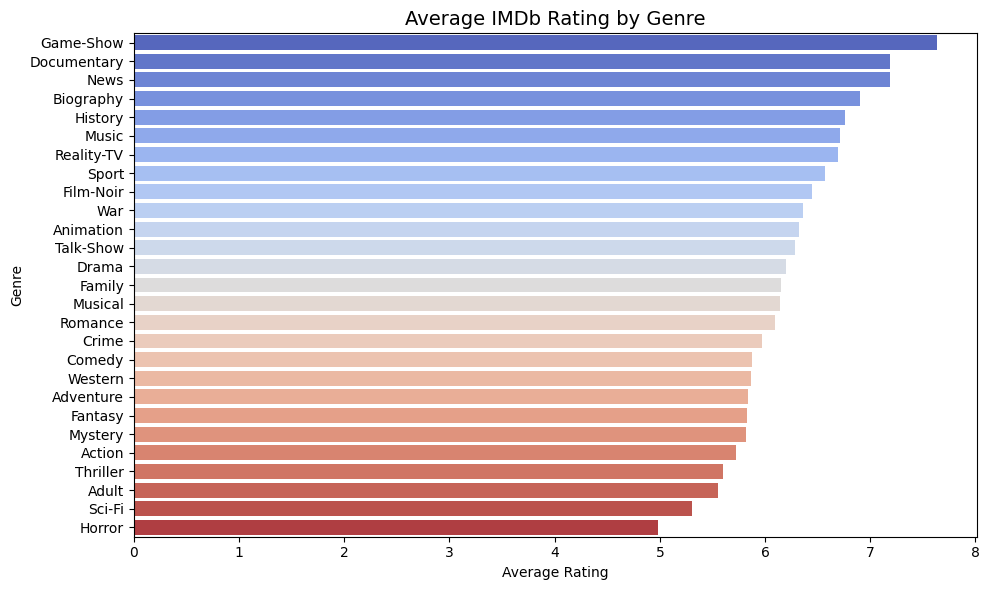

In [68]:
# Average Rating per Genre

query = """
SELECT 
    g.genreName AS genre,
    ROUND(AVG(r.averageRating), 2) AS avg_rating,
    COUNT(*) AS num_movies
FROM dim_movie AS m
JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
JOIN genre_dt AS g ON tg.genreID = g.genreID
JOIN title_ratings AS r ON m.tconst = r.tconst
GROUP BY g.genreName
ORDER BY avg_rating DESC;
"""

with engine.connect() as conn:
    genre_ratings = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_rating", y="genre", hue="genre", data=genre_ratings, palette="coolwarm")
plt.title("Average IMDb Rating by Genre", fontsize=14)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

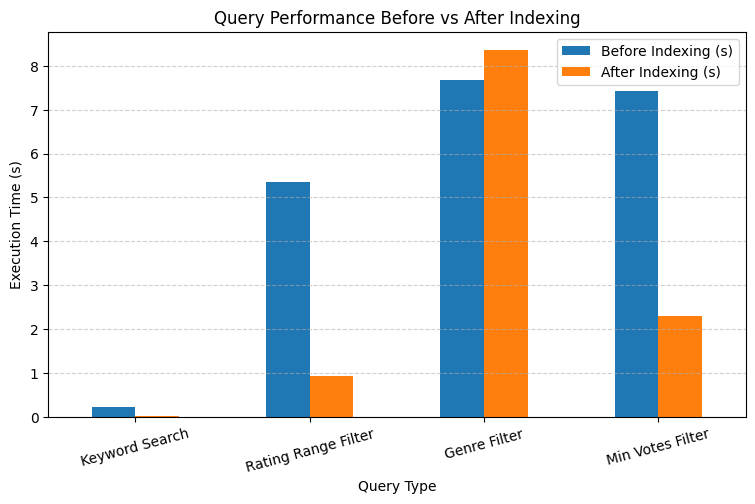

In [65]:
performance = pd.DataFrame({
    "Query": [
        "Keyword Search",
        "Rating Range Filter",
        "Genre Filter",
        "Min Votes Filter"
    ],
    "Before Indexing (s)": [0.217, 5.345, 7.675, 7.419],
    "After Indexing (s)": [0.010, 0.923, 8.353, 2.310]
})

performance.plot(
    x="Query",
    y=["Before Indexing (s)", "After Indexing (s)"],
    kind="bar",
    figsize=(9,5),
    title="Query Performance Before vs After Indexing",
    xlabel="Query Type",
    ylabel="Execution Time (s)",
    rot=15
)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()